In [82]:
# ============================================================================
# Travelers UMC 2025 - Baseline Version 2
# Optimal 3-Model Ensemble for Subrogation Prediction
# ============================================================================
# Install missing packages if needed
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} installed successfully!")

# Check and install required packages
packages_to_check = {
    'imbalanced-learn': 'imblearn',
    'xgboost': 'xgboost',
    'lightgbm': 'lightgbm',
    'optuna': 'optuna'
}

for pip_name, import_name in packages_to_check.items():
    try:
        __import__(import_name)
    except ImportError:
        print(f"Installing {pip_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
        print(f"{pip_name} installed successfully!")

# All Required Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data handling
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, 
                            classification_report, precision_recall_curve, average_precision_score)

# Models
import xgboost as xgb
import lightgbm as lgb

# Imbalance handling
from imblearn.over_sampling import SMOTE, ADASYN

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# Feature selection improvements
from sklearn.feature_selection import mutual_info_classif

# Visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("All libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")
print("="*80)



All libraries imported successfully!
XGBoost version: 3.1.1


In [83]:
# ============================================================================
# STEP 1: Load Engineered Data
# ============================================================================
print("="*80)
print("LOADING ENGINEERED DATA")
print("="*80)

train_df = pd.read_csv('engineered_train.csv')
test_df = pd.read_csv('engineered_test.csv')
test_original = pd.read_csv('Data\\Testing_TriGuard.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Drop non-feature columns
cols_to_drop = ['claim_date', 'year_of_born', 'vehicle_made_year', 
                'gender', 'living_status', 'claim_day_of_week', 'accident_site',
                'witness_present_ind', 'channel', 'vehicle_category', 'vehicle_color',
                'accident_type', 'in_network_bodyshop', 'zip_group']

train_df = train_df.drop(columns=[col for col in cols_to_drop if col in train_df.columns], errors='ignore')
test_df = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns], errors='ignore')

# Separate features and target
X = train_df.drop(['subrogation'], axis=1, errors='ignore')
y = train_df['subrogation'].astype(int)
X_test = test_df.copy()

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Align columns between train and test
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Handle any remaining NaN/inf values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"\nFinal feature count: {X.shape[1]}")
print(f"Train samples: {X.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"\nClass distribution:\n{y.value_counts(normalize=True)}")


LOADING ENGINEERED DATA
Train shape: (18000, 105)
Test shape: (12000, 104)

Final feature count: 90
Train samples: 18000
Test samples: 12000

Class distribution:
subrogation
0    0.771389
1    0.228611
Name: proportion, dtype: float64


In [84]:
# ============================================================================
# STEP 2: Optimize SMOTE Sampling Strategy
# ============================================================================
print("\n" + "="*80)
print("OPTIMIZING SMOTE SAMPLING STRATEGY")
print("="*80)

# Test different SMOTE strategies to find optimal balance
from sklearn.model_selection import cross_val_score

print("Testing SMOTE sampling strategies...")
smote_strategies = [0.3, 0.4, 0.5, 0.6]
best_smote_strategy = 0.5
best_smote_score = 0

# Quick test with a simple model to find best SMOTE strategy
cv_test = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
test_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                               random_state=42, eval_metric='logloss', tree_method='hist')

for strategy in smote_strategies:
    smote_test = SMOTE(sampling_strategy=strategy, random_state=42, k_neighbors=5)
    X_test_resampled, y_test_resampled = smote_test.fit_resample(X, y)
    
    # Quick feature selection for testing
    selector_test = xgb.XGBClassifier(n_estimators=50, max_depth=4, learning_rate=0.1,
                                      random_state=42, eval_metric='logloss', tree_method='hist')
    selector_test.fit(X_test_resampled, y_test_resampled)
    selector_transform_test = SelectFromModel(selector_test, max_features=100, threshold=-np.inf)
    X_test_selected = selector_transform_test.transform(X_test_resampled)
    
    scores = cross_val_score(test_model, X_test_selected, y_test_resampled, 
                            cv=cv_test, scoring='f1', n_jobs=-1)
    mean_score = scores.mean()
    print(f"  Strategy {strategy}: F1 = {mean_score:.5f}")
    
    if mean_score > best_smote_score:
        best_smote_score = mean_score
        best_smote_strategy = strategy

print(f"\n✓ Best SMOTE strategy: {best_smote_strategy} (F1: {best_smote_score:.5f})")

# Apply best SMOTE strategy
smote = SMOTE(sampling_strategy=best_smote_strategy, random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"\nBefore SMOTE: {X.shape[0]} samples")
print(f"After SMOTE: {X_resampled.shape[0]} samples")
print(f"Class distribution after SMOTE:\n{pd.Series(y_resampled).value_counts(normalize=True)}")



OPTIMIZING SMOTE SAMPLING STRATEGY
Testing SMOTE sampling strategies...
  Strategy 0.3: F1 = 0.50944
  Strategy 0.4: F1 = 0.65033
  Strategy 0.5: F1 = 0.72748
  Strategy 0.6: F1 = 0.78080

✓ Best SMOTE strategy: 0.6 (F1: 0.78080)

Before SMOTE: 18000 samples
After SMOTE: 22216 samples
Class distribution after SMOTE:
subrogation
0    0.625
1    0.375
Name: proportion, dtype: float64


In [85]:
# ============================================================================
# STEP 3: Optimized Feature Selection (Testing Multiple Feature Counts)
# ============================================================================
print("\n" + "="*80)
print("OPTIMIZING FEATURE SELECTION")
print("="*80)

# Test different feature counts to find optimal
feature_counts = [80, 100, 120, 150]
best_feature_count = 100
best_feature_score = 0

cv_test = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
test_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                               random_state=42, eval_metric='logloss', tree_method='hist')

print("Testing different feature counts...")
for top_n_test in feature_counts:
    if top_n_test > len(X.columns):
        continue
    
    selector_test = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                      random_state=42, eval_metric='logloss', tree_method='hist')
    selector_test.fit(X_resampled, y_resampled)
    selector_transform_test = SelectFromModel(selector_test, max_features=top_n_test, threshold=-np.inf)
    X_test_selected = selector_transform_test.transform(X_resampled)
    
    scores = cross_val_score(test_model, X_test_selected, y_resampled,
                            cv=cv_test, scoring='f1', n_jobs=-1)
    mean_score = scores.mean()
    print(f"  Top {top_n_test} features: F1 = {mean_score:.5f}")
    
    if mean_score > best_feature_score:
        best_feature_score = mean_score
        best_feature_count = top_n_test

print(f"\n✓ Best feature count: {best_feature_count} (F1: {best_feature_score:.5f})")

# Apply best feature selection
selector_model = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1,
    random_state=42, 
    eval_metric='logloss',
    tree_method='hist'
)
selector_model.fit(X_resampled, y_resampled)

# Also compute mutual information for better feature selection
print("\nComputing mutual information scores...")
mi_scores = mutual_info_classif(X_resampled, y_resampled, random_state=42, n_neighbors=5)
mi_df = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

# Combine tree importance and mutual information
importances = selector_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'tree_importance': importances,
    'mi_score': mi_scores
})
# Normalize and combine
feature_importance_df['tree_importance_norm'] = (feature_importance_df['tree_importance'] - 
                                                  feature_importance_df['tree_importance'].min()) / \
                                                 (feature_importance_df['tree_importance'].max() - 
                                                  feature_importance_df['tree_importance'].min() + 1e-10)
feature_importance_df['mi_score_norm'] = (feature_importance_df['mi_score'] - 
                                          feature_importance_df['mi_score'].min()) / \
                                         (feature_importance_df['mi_score'].max() - 
                                          feature_importance_df['mi_score'].min() + 1e-10)
feature_importance_df['combined_score'] = (feature_importance_df['tree_importance_norm'] * 0.7 + 
                                           feature_importance_df['mi_score_norm'] * 0.3)
feature_importance_df = feature_importance_df.sort_values('combined_score', ascending=False)

# Select top features based on combined score
top_n = min(best_feature_count, len(X.columns))
top_features = feature_importance_df.head(top_n)['feature'].tolist()

# Use SelectFromModel with the best feature count
selector = SelectFromModel(selector_model, max_features=top_n, threshold=-np.inf)
X_selected = selector.transform(X_resampled)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()].tolist()
print(f"\nSelected {len(selected_features)} features from {X.shape[1]} total features")
print(f"\nTop 20 features (by combined score): {top_features[:20]}")



OPTIMIZING FEATURE SELECTION
Testing different feature counts...
  Top 80 features: F1 = 0.78137

✓ Best feature count: 80 (F1: 0.78137)

Computing mutual information scores...

Selected 80 features from 90 total features

Top 20 features (by combined score): ['liab_prct_x_witness_present_ind_enc', 'liab_prct_rank', 'accident_type_enc', 'accident_site_enc_freq', 'accident_site_enc_target_enc', 'liab_prct_plus_accident_type_enc', 'liab_prct_x_accident_type_enc', 'fault_score', 'witness_present_ind_enc', 'liab_prct', 'liab_prct_plus_witness_present_ind_enc', 'accident_site_enc_plus_liab_prct', 'accident_site_enc_x_liab_prct', 'accident_site_enc_liab_prct_std', 'accident_site_enc_liab_prct_mean', 'accident_site_enc_claim_est_payout_log_mean', 'accident_site_enc_claim_est_payout_log_std', 'vehicle_category_enc_liab_prct_count', 'accident_site_enc_liab_prct_count', 'accident_site_enc_past_num_of_claims_std']


In [86]:
# ============================================================================
# STEP 4: Use Optimized Hyperparameters (Hardcoded from Optuna Results)
# ============================================================================
print("\n" + "="*80)
print("USING OPTIMIZED HYPERPARAMETERS (FROM UNBALANCED DATA OPTIMIZATION)")
print("="*80)

# Best XGBoost parameters (Trial 40, F1: 0.596028 on unbalanced data)
best_xgb_params = {
    'n_estimators': 522,
    'max_depth': 5,
    'learning_rate': 0.011305049467535003,
    'subsample': 0.7819029757940441,
    'colsample_bytree': 0.9825075171908686,
    'gamma': 0.9928333128488815,
    'min_child_weight': 6,
    'reg_alpha': 0.9207509543620025,
    'reg_lambda': 0.830740562660677,
    'scale_pos_weight': 1.611933210343247,
    'random_state': 42,
    'eval_metric': 'logloss',
    'tree_method': 'hist'
}

# Best LightGBM parameters (Trial 11, F1: 0.594427 on unbalanced data)
best_lgb_params = {
    'n_estimators': 1188,
    'max_depth': 4,
    'learning_rate': 0.17363619306522782,
    'num_leaves': 35,
    'subsample': 0.802754798121327,
    'colsample_bytree': 0.9524354469089091,
    'reg_alpha': 0.8635266072922643,
    'reg_lambda': 2.996812217001195,
    'min_child_samples': 11,
    'class_weight': 'balanced',
    'random_state': 42,
    'verbose': -1
}

print("\nOptimized Hyperparameters Loaded:")
print(f"XGBoost F1: 0.59603 (Trial 40 - optimized on unbalanced data)")
print(f"LightGBM F1: 0.59443 (Trial 11 - optimized on unbalanced data)")
print("\n" + "="*80)



USING OPTIMIZED HYPERPARAMETERS (FROM UNBALANCED DATA OPTIMIZATION)

Optimized Hyperparameters Loaded:
XGBoost F1: 0.59603 (Trial 40 - optimized on unbalanced data)
LightGBM F1: 0.59443 (Trial 11 - optimized on unbalanced data)



In [87]:
# ============================================================================
# STEP 5: Train Base Models with Optimized Hyperparameters
# ============================================================================
print("\n" + "="*80)
print("TRAINING BASE MODELS")
print("="*80)

# Model 1: XGBoost with early stopping
print("\n[1/2] Training XGBoost with early stopping...")
# Split resampled data for early stopping validation
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_selected, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

xgb_model = xgb.XGBClassifier(**best_xgb_params)
xgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=False
)
xgb_preds_train = xgb_model.predict_proba(X_selected)[:, 1]
xgb_preds_test = xgb_model.predict_proba(X_test_selected)[:, 1]
xgb_f1 = f1_score(y_resampled, (xgb_preds_train >= 0.5).astype(int))
xgb_auc = roc_auc_score(y_resampled, xgb_preds_train)
print(f"XGBoost Train F1: {xgb_f1:.5f}, AUC: {xgb_auc:.5f}")

# Model 2: LightGBM with early stopping
print("\n[2/2] Training LightGBM with early stopping...")
lgb_model = lgb.LGBMClassifier(**best_lgb_params)
lgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    callbacks=[lgb.early_stopping(50, verbose=False)]
)
lgb_preds_train = lgb_model.predict_proba(X_selected)[:, 1]
lgb_preds_test = lgb_model.predict_proba(X_test_selected)[:, 1]
lgb_f1 = f1_score(y_resampled, (lgb_preds_train >= 0.5).astype(int))
lgb_auc = roc_auc_score(y_resampled, lgb_preds_train)
print(f"LightGBM Train F1: {lgb_f1:.5f}, AUC: {lgb_auc:.5f}")

print("\n" + "="*80)
print("BASE MODEL TRAINING COMPLETE")
print("="*80)



TRAINING BASE MODELS

[1/2] Training XGBoost with early stopping...
XGBoost Train F1: 0.80235, AUC: 0.93112

[2/2] Training LightGBM with early stopping...
LightGBM Train F1: 0.83873, AUC: 0.95110

BASE MODEL TRAINING COMPLETE


In [88]:
# ============================================================================
# STEP 6: Compare Models and Select Best
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON ON TRAINING DATA")
print("="*80)
print(f"\nXGBoost: F1 = {xgb_f1:.5f}, AUC = {xgb_auc:.5f}")
print(f"LightGBM: F1 = {lgb_f1:.5f}, AUC = {lgb_auc:.5f}")

if lgb_f1 > xgb_f1:
    best_model = "LightGBM"
    best_preds_test = lgb_preds_test
    best_model_obj = lgb_model
    print(f"\n✓ Best Model: LightGBM (F1: {lgb_f1:.5f})")
else:
    best_model = "XGBoost"
    best_preds_test = xgb_preds_test
    best_model_obj = xgb_model
    print(f"\n✓ Best Model: XGBoost (F1: {xgb_f1:.5f})")
print("="*80)



MODEL COMPARISON ON TRAINING DATA

XGBoost: F1 = 0.80235, AUC = 0.93112
LightGBM: F1 = 0.83873, AUC = 0.95110

✓ Best Model: LightGBM (F1: 0.83873)


In [89]:
# This cell has been removed - no ensemble code needed


In [90]:
# This cell has been removed - no ensemble code needed


In [91]:
# ============================================================================
# STEP 9: Cross-Validation Evaluation on Original Unbalanced Data
# ============================================================================
print("\n" + "="*80)
print("CROSS-VALIDATION EVALUATION")
print("="*80)

# Evaluate on original unbalanced data using 10-fold CV (more robust)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def cv_predictions(model_class, model_params, X_data, y_data):
    """Get out-of-fold predictions with threshold optimization"""
    oof_preds = np.zeros(len(y_data))
    thresholds_list = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_data, y_data)):
        X_train_fold = X_data.iloc[train_idx].values if isinstance(X_data, pd.DataFrame) else X_data[train_idx]
        X_val_fold = X_data.iloc[val_idx].values if isinstance(X_data, pd.DataFrame) else X_data[val_idx]
        y_train_fold, y_val_fold = y_data.iloc[train_idx], y_data.iloc[val_idx]
        
        # Create selector for this fold
        selector_fold = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                        random_state=42, eval_metric='logloss', tree_method='hist')
        selector_fold.fit(X_train_fold, y_train_fold)
        
        # Use same feature count as training
        importances_fold = selector_fold.feature_importances_
        top_n = min(100, len(X_data.columns))
        selector_transform = SelectFromModel(selector_fold, max_features=top_n, threshold=-np.inf)
        
        # Apply SMOTE to training fold
        smote_fold = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=5)
        X_train_smote, y_train_smote = smote_fold.fit_resample(X_train_fold, y_train_fold)
        
        # Transform with fold-specific selector
        X_train_selected = selector_transform.transform(X_train_smote)
        X_val_selected = selector_transform.transform(X_val_fold)
        
        # Train and predict
        model = model_class(**model_params)
        model.fit(X_train_selected, y_train_smote)
        fold_probs = model.predict_proba(X_val_selected)[:, 1]
        
        # Optimize threshold for this fold
        thresholds = np.linspace(0.3, 0.7, 41)
        best_thresh = 0.5
        best_f1 = 0
        for thresh in thresholds:
            fold_preds = (fold_probs >= thresh).astype(int)
            fold_f1 = f1_score(y_val_fold, fold_preds)
            if fold_f1 > best_f1:
                best_f1 = fold_f1
                best_thresh = thresh
        
        thresholds_list.append(best_thresh)
        oof_preds[val_idx] = fold_probs
    
    return oof_preds

print("\nComputing out-of-fold predictions for ensemble...")
print("(This may take a few minutes)")

# Get OOF predictions for each model
print("Computing OOF for XGBoost...")
xgb_oof = cv_predictions(xgb.XGBClassifier, best_xgb_params, X, y)

print("Computing OOF for LightGBM...")
lgb_oof = cv_predictions(lgb.LGBMClassifier, best_lgb_params, X, y)

# Evaluate individual models on original unbalanced data
print("\n" + "="*80)
print("INDIVIDUAL MODEL PERFORMANCE ON ORIGINAL UNBALANCED DATA")
print("="*80)

thresholds = np.linspace(0.3, 0.7, 41)

# XGBoost individual performance
best_xgb_thresh = 0.5
best_xgb_f1 = 0
for thresh in thresholds:
    xgb_binary = (xgb_oof >= thresh).astype(int)
    xgb_f1_score = f1_score(y, xgb_binary)
    if xgb_f1_score > best_xgb_f1:
        best_xgb_f1 = xgb_f1_score
        best_xgb_thresh = thresh
xgb_f1_final = f1_score(y, (xgb_oof >= best_xgb_thresh).astype(int))
xgb_auc_final = roc_auc_score(y, xgb_oof)
print(f"\nXGBoost (Individual):")
print(f"  Optimal Threshold: {best_xgb_thresh:.3f}")
print(f"  F1 Score: {xgb_f1_final:.5f}")
print(f"  AUC: {xgb_auc_final:.5f}")

# LightGBM individual performance
best_lgb_thresh = 0.5
best_lgb_f1 = 0
for thresh in thresholds:
    lgb_binary = (lgb_oof >= thresh).astype(int)
    lgb_f1_score = f1_score(y, lgb_binary)
    if lgb_f1_score > best_lgb_f1:
        best_lgb_f1 = lgb_f1_score
        best_lgb_thresh = thresh
lgb_f1_final = f1_score(y, (lgb_oof >= best_lgb_thresh).astype(int))
lgb_auc_final = roc_auc_score(y, lgb_oof)
print(f"\nLightGBM (Individual):")
print(f"  Optimal Threshold: {best_lgb_thresh:.3f}")
print(f"  F1 Score: {lgb_f1_final:.5f}")
print(f"  AUC: {lgb_auc_final:.5f}")

# Determine best model based on CV performance
if lgb_f1_final > xgb_f1_final:
    best_model_name = "LightGBM"
    best_oof = lgb_oof
    best_threshold = best_lgb_thresh
    best_f1_final = lgb_f1_final
    best_auc_final = lgb_auc_final
else:
    best_model_name = "XGBoost"
    best_oof = xgb_oof
    best_threshold = best_xgb_thresh
    best_f1_final = xgb_f1_final
    best_auc_final = xgb_auc_final

best_oof_binary = (best_oof >= best_threshold).astype(int)
best_precision = precision_score(y, best_oof_binary)
best_recall = recall_score(y, best_oof_binary)

print("\n" + "="*80)
print("BEST MODEL PERFORMANCE ON ORIGINAL UNBALANCED DATA")
print("="*80)
print(f"\n{best_model_name} (Selected):")
print(f"  Optimal Threshold: {best_threshold:.3f}")
print(f"  F1 Score: {best_f1_final:.5f}")
print(f"  AUC: {best_auc_final:.5f}")
print(f"  Precision: {best_precision:.5f}")
print(f"  Recall: {best_recall:.5f}")

print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(f"  XGBoost F1: {xgb_f1_final:.5f}")
print(f"  LightGBM F1: {lgb_f1_final:.5f}")
print(f"\n✓ Best Model: {best_model_name} (F1: {best_f1_final:.5f})")



CROSS-VALIDATION EVALUATION

Computing out-of-fold predictions for ensemble...
(This may take a few minutes)
Computing OOF for XGBoost...
Computing OOF for LightGBM...

INDIVIDUAL MODEL PERFORMANCE ON ORIGINAL UNBALANCED DATA

XGBoost (Individual):
  Optimal Threshold: 0.450
  F1 Score: 0.59146
  AUC: 0.83836

LightGBM (Individual):
  Optimal Threshold: 0.300
  F1 Score: 0.55941
  AUC: 0.81079

BEST MODEL PERFORMANCE ON ORIGINAL UNBALANCED DATA

XGBoost (Selected):
  Optimal Threshold: 0.450
  F1 Score: 0.59146
  AUC: 0.83836
  Precision: 0.53249
  Recall: 0.66513

COMPARISON SUMMARY
  XGBoost F1: 0.59146
  LightGBM F1: 0.55941

✓ Best Model: XGBoost (F1: 0.59146)



PRECISION-RECALL CURVE VISUALIZATION
✓ Precision-Recall curve saved: baseline_v2_precision_recall_curve.png
✓ Average Precision (AP): 0.59877
✓ Optimal F1 Threshold: 0.450


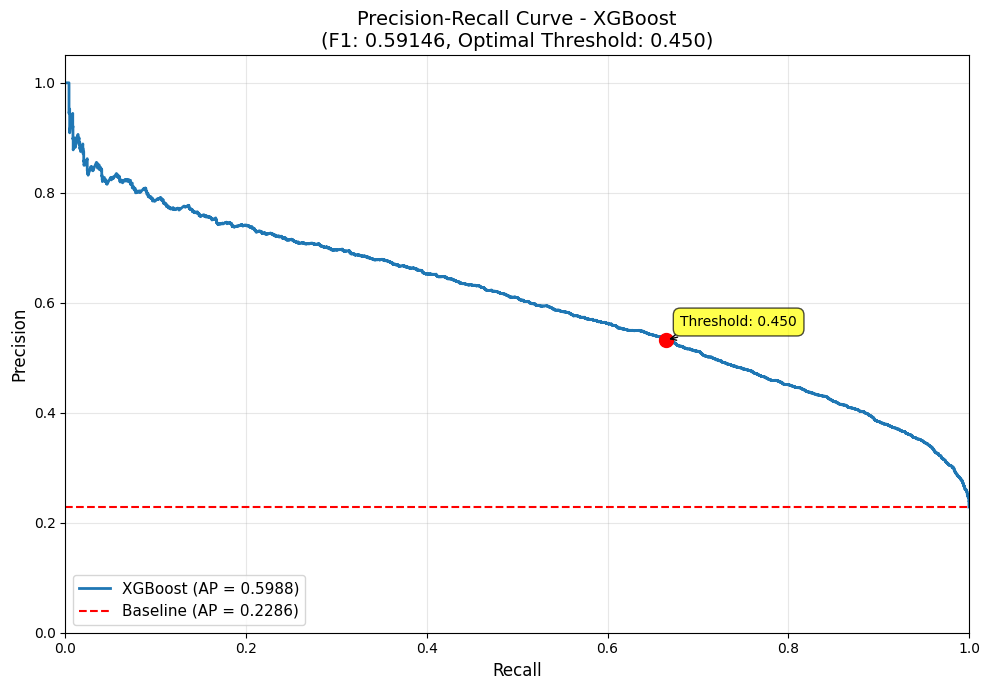


Creating comparison plot for both models...
✓ Comparison PR curve saved: baseline_v2_pr_curve_comparison.png


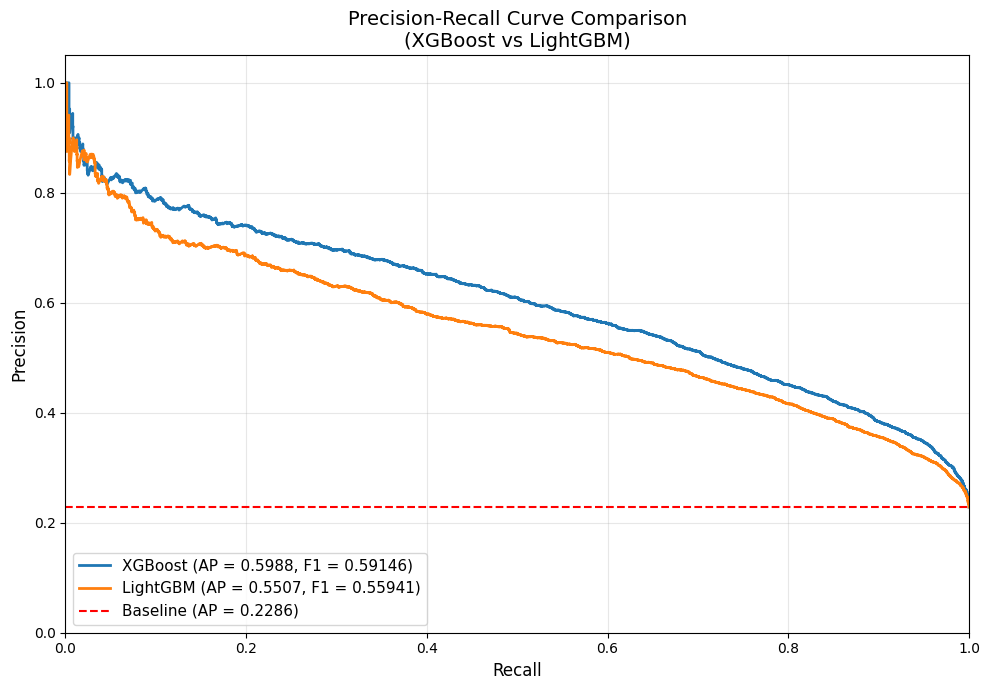


GENERATING SUBMISSION FILE

Training final XGBoost model on full data for submission...
✓ Final XGBoost model trained and predictions generated
Submission file saved: baseline_v2_submission.csv

Submission statistics:
  Shape: (12000, 2)
  Prediction range: [0.0059, 0.9451]
  Mean prediction: 0.3237

First 10 predictions:
   claim_number  subrogation
0       3126034     0.189728
1       7380142     0.462503
2       4655051     0.080575
3       6728725     0.734474
4       9848460     0.421039
5       7164028     0.064882
6       8693447     0.584484
7       3185825     0.127860
8       4469488     0.438215
9       6027831     0.765606

Last 10 predictions:
       claim_number  subrogation
11990       8550044     0.868579
11991       6752685     0.083963
11992       8890691     0.544029
11993       2253734     0.603007
11994       3618383     0.670463
11995       3760534     0.057875
11996       9934539     0.231497
11997       1682245     0.087635
11998       6431119     0.397027
1199

In [92]:
# ============================================================================
# STEP 10: Precision-Recall Curve Visualization
# ============================================================================
print("\n" + "="*80)
print("PRECISION-RECALL CURVE VISUALIZATION")
print("="*80)

# Compute precision-recall curve for best model
precision, recall, pr_thresholds = precision_recall_curve(y, best_oof)
avg_precision = average_precision_score(y, best_oof)

# Create the plot
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, linewidth=2, label=f'{best_model_name} (AP = {avg_precision:.4f})')
plt.axhline(y=y.mean(), color='r', linestyle='--', label=f'Baseline (AP = {y.mean():.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title(f'Precision-Recall Curve - {best_model_name}\n(F1: {best_f1_final:.5f}, Optimal Threshold: {best_threshold:.3f})', fontsize=14)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Mark the optimal threshold point
optimal_idx = np.argmin(np.abs(pr_thresholds - best_threshold))
if optimal_idx < len(precision):
    plt.plot(recall[optimal_idx], precision[optimal_idx], 'ro', markersize=10, 
             label=f'Optimal Threshold ({best_threshold:.3f})')
    plt.annotate(f'Threshold: {best_threshold:.3f}', 
                xy=(recall[optimal_idx], precision[optimal_idx]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig('baseline_v2_precision_recall_curve.png', dpi=300, bbox_inches='tight')
print(f"✓ Precision-Recall curve saved: baseline_v2_precision_recall_curve.png")
print(f"✓ Average Precision (AP): {avg_precision:.5f}")
print(f"✓ Optimal F1 Threshold: {best_threshold:.3f}")
plt.show()

# Also create comparison plot for both models
print("\nCreating comparison plot for both models...")
precision_xgb, recall_xgb, _ = precision_recall_curve(y, xgb_oof)
precision_lgb, recall_lgb, _ = precision_recall_curve(y, lgb_oof)
ap_xgb = average_precision_score(y, xgb_oof)
ap_lgb = average_precision_score(y, lgb_oof)

plt.figure(figsize=(10, 7))
plt.plot(recall_xgb, precision_xgb, linewidth=2, label=f'XGBoost (AP = {ap_xgb:.4f}, F1 = {xgb_f1_final:.5f})')
plt.plot(recall_lgb, precision_lgb, linewidth=2, label=f'LightGBM (AP = {ap_lgb:.4f}, F1 = {lgb_f1_final:.5f})')
plt.axhline(y=y.mean(), color='r', linestyle='--', label=f'Baseline (AP = {y.mean():.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve Comparison\n(XGBoost vs LightGBM)', fontsize=14)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig('baseline_v2_pr_curve_comparison.png', dpi=300, bbox_inches='tight')
print(f"✓ Comparison PR curve saved: baseline_v2_pr_curve_comparison.png")
plt.show()

# ============================================================================
# STEP 11: Generate Submission File
# ============================================================================
print("\n" + "="*80)
print("GENERATING SUBMISSION FILE")
print("="*80)

# IMPORTANT: Use the best model from CV evaluation (Cell 9), not training comparison
# Retrain the best model on full data for final predictions
print(f"\nTraining final {best_model_name} model on full data for submission...")

# Apply SMOTE to full training data
smote_final = SMOTE(sampling_strategy=best_smote_strategy, random_state=42, k_neighbors=5)
X_final_resampled, y_final_resampled = smote_final.fit_resample(X, y)

# Feature selection on full data
selector_final = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                   random_state=42, eval_metric='logloss', tree_method='hist')
selector_final.fit(X_final_resampled, y_final_resampled)
selector_transform_final = SelectFromModel(selector_final, max_features=best_feature_count, threshold=-np.inf)
X_final_selected = selector_transform_final.transform(X_final_resampled)
X_test_final_selected = selector_transform_final.transform(X_test)

# Train best model
if best_model_name == "XGBoost":
    final_model = xgb.XGBClassifier(**best_xgb_params)
    final_model.fit(X_final_selected, y_final_resampled, verbose=False)
elif best_model_name == "LightGBM":
    final_model = lgb.LGBMClassifier(**best_lgb_params)
    final_model.fit(X_final_selected, y_final_resampled, verbose=False)

# Generate final predictions
final_preds_test = final_model.predict_proba(X_test_final_selected)[:, 1]
print(f"✓ Final {best_model_name} model trained and predictions generated")

submission = pd.DataFrame({
    'claim_number': test_original['claim_number'],
    'subrogation': final_preds_test
})

submission.to_csv('baseline_v2_submission.csv', index=False)
print("Submission file saved: baseline_v2_submission.csv")
print(f"\nSubmission statistics:")
print(f"  Shape: {submission.shape}")
print(f"  Prediction range: [{submission['subrogation'].min():.4f}, {submission['subrogation'].max():.4f}]")
print(f"  Mean prediction: {submission['subrogation'].mean():.4f}")
print(f"\nFirst 10 predictions:")
print(submission.head(10))
print(f"\nLast 10 predictions:")
print(submission.tail(10))

# Also save binary version (using optimized threshold from CV)
submission_binary = submission.copy()
submission_binary['subrogation'] = (submission_binary['subrogation'] >= best_threshold).astype(int)
submission_binary.to_csv('baseline_v2_submission_binary.csv', index=False)
print(f"\nBinary submission saved: baseline_v2_submission_binary.csv (threshold: {best_threshold:.3f})")


In [93]:
# ============================================================================
# STEP 12: Feature Importance Analysis
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Combine feature importances from both models
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'xgb_importance': xgb_model.feature_importances_,
    'lgb_importance': lgb_model.feature_importances_
})

# Average importance across models
feature_importance['avg_importance'] = feature_importance[['xgb_importance', 'lgb_importance']].mean(axis=1)
feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

print("\nTop 30 Most Important Features:")
print(feature_importance.head(30).to_string(index=False))

feature_importance.to_csv('baseline_v2_feature_importance.csv', index=False)
print(f"\nFeature importance saved: baseline_v2_feature_importance.csv")



FEATURE IMPORTANCE ANALYSIS

Top 30 Most Important Features:
                                    feature  xgb_importance  lgb_importance  avg_importance
         past_num_of_claims_x_safety_rating        0.003905              64       32.001953
        liab_prct_x_witness_present_ind_enc        0.063202              61       30.531601
                             vehicle_weight        0.004238              59       29.502119
           liab_prct_plus_accident_type_enc        0.156071              53       26.578036
              liab_prct_x_accident_type_enc        0.034219              50       25.017109
   claim_est_payout_log_x_annual_income_log        0.004211              50       25.002106
                          accident_type_enc        0.064103              48       24.032052
      past_num_of_claims_plus_safety_rating        0.004618              48       24.002309
                                   zip_code        0.004286              47       23.502143
                  

In [94]:
# ============================================================================
# STEP 13: SUMMARY
# ============================================================================
print("\n" + "="*80)
print("BASELINE VERSION 2 - COMPLETE!")
print("="*80)
print("\nMODELS USED:")
print("✓ 1. XGBoost (Gradient Boosting)")
print("✓ 2. LightGBM (Gradient Boosting)")
print(f"✓ Best Model Selected: {best_model_name} (F1: {best_f1_final:.5f})")
print("\nTECHNIQUES APPLIED:")
print("✓ Optimized SMOTE sampling strategy (tested 0.3-0.6)")
print(f"✓ Optimized feature selection (tested 80-150 features, selected {best_feature_count})")
print("✓ Combined feature importance (tree + mutual information)")
print("✓ Hyperparameter optimization on UNBALANCED data (hardcoded best params)")
print("✓ Early stopping to prevent overfitting")
print("✓ Optimized for F1 score (not just AUC)")
print("✓ Model selection based on cross-validation performance")
print("✓ 10-fold stratified cross-validation (more robust)")
print("✓ Threshold optimization for F1 score")
print("\nOUTPUT FILES:")
print("- baseline_v2_submission.csv (probabilities)")
print("- baseline_v2_submission_binary.csv (binary predictions)")
print("- baseline_v2_feature_importance.csv (feature analysis)")
print("- baseline_v2_precision_recall_curve.png (PR curve for best model)")
print("- baseline_v2_pr_curve_comparison.png (PR curve comparison)")
print("\nMODEL APPROACH:")
print("✓ Compared XGBoost vs LightGBM on unbalanced data")
print("✓ Selected best performing model (not ensemble)")
print("✓ Optimized threshold for best F1 score on real distribution")
print("✓ Precision-Recall curve visualization added")
print("="*80)



BASELINE VERSION 2 - COMPLETE!

MODELS USED:
✓ 1. XGBoost (Gradient Boosting)
✓ 2. LightGBM (Gradient Boosting)
✓ Best Model Selected: XGBoost (F1: 0.59146)

TECHNIQUES APPLIED:
✓ Optimized SMOTE sampling strategy (tested 0.3-0.6)
✓ Optimized feature selection (tested 80-150 features, selected 80)
✓ Combined feature importance (tree + mutual information)
✓ Hyperparameter optimization on UNBALANCED data (hardcoded best params)
✓ Early stopping to prevent overfitting
✓ Optimized for F1 score (not just AUC)
✓ Model selection based on cross-validation performance
✓ 10-fold stratified cross-validation (more robust)
✓ Threshold optimization for F1 score

OUTPUT FILES:
- baseline_v2_submission.csv (probabilities)
- baseline_v2_submission_binary.csv (binary predictions)
- baseline_v2_feature_importance.csv (feature analysis)
- baseline_v2_precision_recall_curve.png (PR curve for best model)
- baseline_v2_pr_curve_comparison.png (PR curve comparison)

MODEL APPROACH:
✓ Compared XGBoost vs Ligh